[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AllenWLynch/MIRA/blob/main/docs/source/notebooks/tutorial_mouse_brain.ipynb)

**MIRA (Probabilistic Multimodal <ins>M</ins>odels for <ins>I</ins>ntegrated <ins>R</ins>egulatory <ins>A</ins>nalysis)** is a comprehensive methodology that systematically contrasts single cell transcription and accessibility to infer the regulatory circuitry driving cells along developmental trajectories. 

MIRA leverages joint topic modeling of cell states and regulatory potential modeling at individual gene loci to:
- jointly represent cell states in an efficient and interpretable latent space
- infer high fidelity lineage trees
- determine key regulators of fate decisions at branch points
- expose the variable influence of local accessibility on transcription at distinct loci

# 10X Mouse Brain Example

This tutorial will review an example MIRA analysis of a [10x Multiome embryonic brain dataset](https://www.10xgenomics.com/resources/datasets/fresh-embryonic-e-18-mouse-brain-5-k-1-standard-2-0-0).

The input data for MIRA is expression (raw gene count) and accessibility (binary peak count) matrices from multimodal RNA-sequencing (scRNA-seq) and Assay for Transposase-Accessible Chromatin-sequencing (scATAC-seq) in the same single cells from any platform. 

Training models using GPU hardware is recommended for improved speed. If using Google Colab, change runtime type (top menu) to use GPU hardware.

## Installation

Install MIRA and some other dependencies:

In [1]:
# !pip install mira-multiome scanpy==1.8.2 numpy==1.20.1

## Imports

In [1]:
import mira
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.INFO)
mira.utils.wide_view() # set the notebook to wide view

## Load Data

In [2]:
# mira.datasets.MouseBrainDataset()

data = sc.read_h5ad('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_dataset.ad')

In [3]:
rna_data = data[:, data.var.feature_types == 'Gene Expression']
atac_data = data[:, data.var.feature_types == 'Peaks']

## Topic Modeling

MIRA’s topic model uses a variational autoencoder approach, intersecting deep learning with probabilistic graphical models, to learn expression and accessibility topics defining each cell’s identity.

Methods involving topic modeling are found under **mira.topics**.

### Data preprocessing

Initial data preprocessing selects cells with high quality data, following standard procedures as recommended by Scanpy. Highly variable genes expressed above a minimum threshold are selected as features for the expression topic model. Here, we use all accessibility peaks as features, but the user may choose to downsample peaks if encountering memory limitations.

The main parameters of the topic model are the columns of the Anndata object that mark which genes to use. The parameter **exogenous_key** marks genes which will be predicted by the decoder. Below, we mark all genes with dispersion above -0.1 as exogenous features. 

The next parameter is **endogenous_key**, which marks genes which will be used by the encoder network. For this, we take the top ~2000 most dispersed genes. In this case, genes with dispersion greater than 0.8.

In [4]:
# Basic preprocessing steps
rna_data.var.index = rna_data.var.index.str.upper()
rna_data.var_names_make_unique()
rna_data = rna_data[:, ~rna_data.var.index.str.startswith('GM')]

sc.pp.filter_cells(rna_data, min_counts = 400)
sc.pp.filter_genes(rna_data, min_cells=15)

rna_data.var['mt'] = rna_data.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_data, qc_vars=['mt'], percent_top=None,
                           log1p=False, inplace=True)

rna_data = rna_data[rna_data.obs.pct_counts_mt < 15, :]
rna_data = rna_data[rna_data.obs.n_genes_by_counts < 8000, :]
sc.pp.filter_genes(rna_data, min_cells=15)

rna_data.raw = rna_data # save raw counts
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)

sc.pp.highly_variable_genes(rna_data, min_disp = -0.1)
rna_data.layers['norm'] = rna_data.X # save normalized count data
rna_data.X = rna_data.raw.X # and reload raw counts
rna_data = rna_data[:, rna_data.var.highly_variable] 
rna_data.var['exog_feature'] = rna_data.var.highly_variable # set column "exog_features" to all genes that met dispersion threshold
rna_data.var.highly_variable = (rna_data.var.dispersions_norm > 0.8) & rna_data.var.exog_feature # set column "highly_variable" to genes that met first criteria and dispersion > 0.8

overlapping_barcodes = np.intersect1d(rna_data.obs_names, atac_data.obs_names) # make sure barcodes are matched between modes
atac_data = atac_data[[i for i in overlapping_barcodes],:]

/Users/sehilyi/opt/miniconda3/envs/mira/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/Users/sehilyi/opt/miniconda3/envs/mira/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/var/folders/rs/7nt0b63d5pn3m6rd7m8zt_6r0000gn/T/ipykernel_2659/53417937.py:25: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna_data.var['exog_feature'] = rna_data.var.highly_variable # set column "exog_features" to all genes that met dispersion threshold


### Hyperparameter tuning

MIRA’s hyperparameter tuning scheme optimizes topic model learning and finds the appropriate number of topics needed to comprehensively yet non-redundantly describe each dataset. Hyperparameters are tuned separately for expression or accessibility topic modeling, which use different generative distributions to account for the distinct statistical properties of each modality (overdispersed scRNA-seq counts and sparse scATAC-seq data).

The expression model is initialized by providing features as determined above. The accessibility model is initialized with all features.

In [6]:
# example_rna_model = mira.topics.ExpressionTopicModel(
#     exogenous_key='exog_feature',
#     endogenous_key='highly_variable',
# )

# example_atac_model = mira.topics.AccessibilityTopicModel() 

In [7]:
# example_rna_model.get_learning_rate_bounds(rna_data)
# example_rna_model.trim_learning_rate_bounds(2.5, 1) # The trim function moves the lower and upper bounds in by a factor of 10 from the spline-estimated learning rate values
# example_rna_model.plot_learning_rate_bounds(figsize=(5,3))

Maximum learning rate bounds for the one-cycle policy learning schedule are selected from the steepest downslope of the learning rate finder curve, which represents the rates with the maximum reduction in loss. Of note, the minimum point on the curve represents the rate at which the loss is no longer improving due to the learning rate being too high. 

For example, for the expression model:

Because the hyperparameter tuning scheme searches many possible values to optimize the model's learning, this step can require some time. To save time for users who would like to explore the outputs of MIRA's trained models in this tutorial (and given the runtime limit on the free version of Colab), we will proceed to train the models with known previously tuned hyperparameters.

If performing hyperparameter optimization on your dataset, use the commands below:


```
tuner = mira.topics.TopicModelTuner(example_rna_model, save_name="example_rna_trials") # instantiates a topic model tuner
tuner.train_test_split(rna_data, train_size = 0.8) # separates cells into train and test sets
study = tuner.tune(rna_data) # runs topic model tuning iterations
example_rna_model = tuner.select_best_model(rna_data) # selects final model
```

### Topic model training

Training the expression topic model with previously tuned hyperparameters:

In [8]:
# example_rna_model = mira.topic_model.ExpressionTopicModel(
#     exogenous_key='exog_feature',
#     endogenous_key='highly_variable',
#     seed=586839805,
#     num_topics=22,
#     decoder_dropout=0.2,
#     encoder_dropout=0.06084789416119217,
#     num_epochs=37, batch_size=32, beta=0.9138240471577984,
#     max_learning_rate=0.04157746477162606,
#     min_learning_rate=0.011551766293393191,
# ).fit(rna_data)

# example_rna_model.save('example_rna_model.pth')

Training the accessibility topic model with previously tuned hyperparameters:

In [9]:
# example_atac_model = mira.topic_model.AccessibilityTopicModel(
#     seed=4136248434,
#     num_topics=13,
#     decoder_dropout=0.2,
#     encoder_dropout=0.07451370312651999,
#     num_epochs=39, batch_size=32, beta=0.9041965277033556,
#     max_learning_rate=0.02638015294961751,
#     min_learning_rate=0.006734638401989464,
# ).fit(atac_data)

# example_atac_model.save('example_atac_model.pth')

Load previously saved models:

In [5]:
rna_model = mira.topic_model.ExpressionTopicModel.load('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_rna_model.pth')
atac_model = mira.topic_model.AccessibilityTopicModel.load('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_atac_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


## Joint topic representation

With trained topic models, one may run **predict** to add columns to the adata for cell-topic compositions, and **get_umap_features** to add transformed representations of the topics as embeddings.

MIRA expression and accessibility topics are combined to generate a joint representation of the data using **mira.utils.make_joint_representation**.

Lastly, with rna_models, one may also impute the predicted expression levels in each cell using **impute**.

In [6]:
rna_model.predict(rna_data)
atac_model.predict(atac_data, batch_size=128)

Predicting latent vars: 100%|███████████████████████████████████████| 10/10 [00:01<00:00,  5.79it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
Predicting latent vars: 100%|███████████████████████████████████████| 37/37 [00:55<00:00,  1.51s/it]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12
INF

In [7]:
atac_model.get_umap_features(atac_data, box_cox = 0.5)
rna_model.get_umap_features(rna_data, box_cox = 0.5)
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)
rna_model.impute(rna_data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.utils:4706 out of 4706 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
Imputing features: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 71.00it/s]
INFO:mira.adata_interface.core:Added layer: imputed


For the brain dataset analysis, we exclude clusters corresponding to the minimal number of Olig1/2+ oligodendrocytes, VWF+/Cdh5+ endothelial cells, and Reelin-positive cells that were too small in number to reliably model and/or from unrelated lineages to the cells of interest for this analysis (astrocytes, excitatory neurons, inhibitory neurons, and their progenitors). Topics exclusively associated with these excluded populations are therefore also excluded from downstream analysis. 

In [8]:
main_barcodes = pd.read_csv("mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_main_barcodes.csv", index_col=0, header=0, names=["barcodes"])

In [9]:
rna_main = rna_data[list(main_barcodes["barcodes"])]
atac_main = atac_data[list(main_barcodes["barcodes"])]

exp_topic_ordered = [f'topic_{i}' for i in     # included topics, custom order
                     [1, 3, 19, 20, 10, 13, 9, 0, 15, 8, 16, 18, 7, 5, 2, 21, 4, 6, 14, 12]]
acc_topic_ordered = [f'topic_{i}' for i in     # included topics, custom order
                     [11, 5, 6, 2, 8, 7, 0, 9, 10, 1, 12, 4, 3]]

A graph is calculated for the cell populations of interest.

In [10]:
sc.pp.neighbors(rna_main, use_rep='X_joint_umap_features', metric='manhattan')
sc.tl.umap(rna_main, min_dist = 0.3, negative_sample_rate=5)

atac_main.obsm['X_umap'] = rna_main.obsm['X_umap']

MIRA **expression** topics are mapped onto a joint representation UMAP.

In [16]:
# # function to flip axes of UMAP
# def flip_axes(plot, x, y):
#   ax = plot.axes
#   for ax_i in ax:
#     if x == True:
#       ax_i.invert_xaxis()
#     if y == True:
#       ax_i.invert_yaxis()

In [17]:
# umap = sc.pl.umap(rna_main, color=exp_topic_ordered, layer='imputed',
#                   frameon=False, color_map='inferno', ncols=5, return_fig=True)
# flip_axes(umap, True, True)

MIRA **accessibility** topics are mapped onto a joint representation UMAP.

In [18]:
# umap = sc.pl.umap(atac_main, color=acc_topic_ordered, layer='imputed',
#                      frameon=False, color_map='viridis', ncols=5, return_fig=True)
# flip_axes(umap, True, True)

## Lineage tree inference

Using the joint topic representation, MIRA constructs high fidelity lineage trees using a new method of defining the branch points between lineages where the probabilities of differentiating into one terminal state diverges from another.

To perform lineage tree inference, found under **mira.time**, the user must specify start and end cells, then follow the steps below:

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 3 diffusion map components.


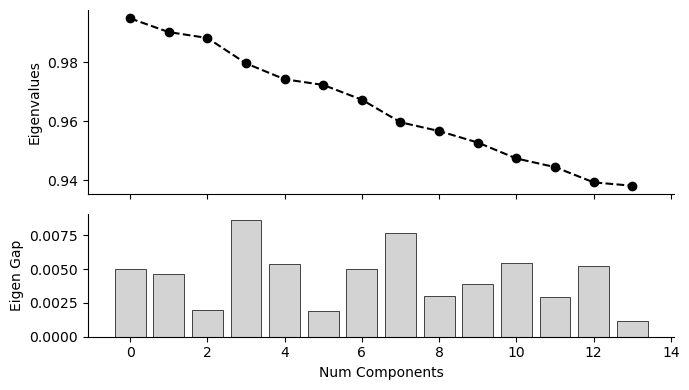

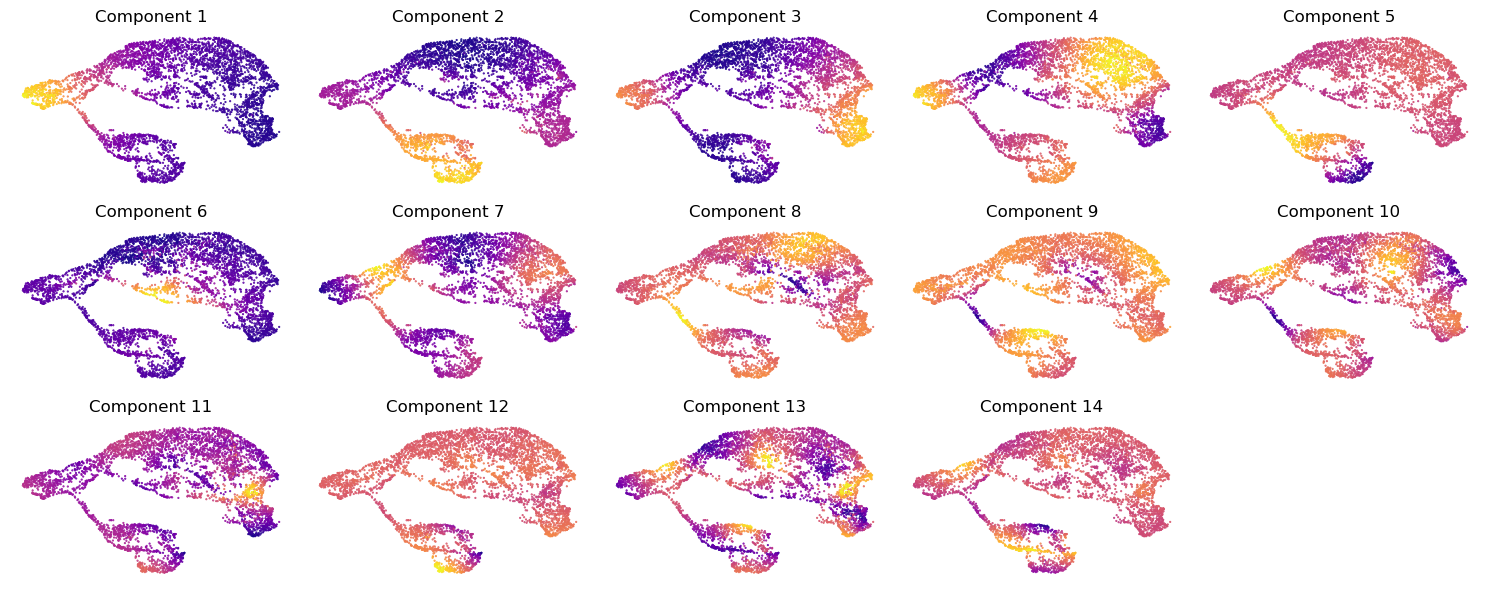

In [11]:
sc.pp.neighbors(rna_main, use_rep='X_joint_umap_features', metric = 'manhattan', n_pcs=None) # calculate a KNN graph from the joint representation
sc.tl.diffmap(rna_main) # denoise the KNN graph by calculating a diffusion map
mira.time.normalize_diffmap(rna_main) # normalize the diffmap dimensions, choose number of dimensions to represent data
mira.pl.plot_eigengap(rna_main)
plt.show()

From the plot above, we can the "Eigen Gap" hueristic peaks at Num Components = 3. Looking at the UMAPs below, we also see that three components adquately describes the difference cell populations. Therefor, in the next step where we calculate a new KNN graph based on the diffusion map, we set `n_pcs = 3`:

In [12]:
rna_main.obsm['X_diffmap'] = rna_main.obsm['X_diffmap'][:, :7]
sc.pp.neighbors(rna_main, use_rep='X_diffmap', key_added='X_diffmap', n_neighbors = 30) # calculate another KNN graph, this time in diffusion space
mira.time.get_connected_components(rna_main) # calculate the subgraphs within the data. Lineage inference may only be used on connected groups of cells.
mira.time.get_transport_map(rna_main, start_cell = 3682) # define a stochastic transport map modeling the differentiation
mira.time.get_branch_probabilities(rna_main, 
                                   terminal_cells= {"Excitatory": 2483, 
                                                    "Astrocyte": 4106, 
                                                    "Inhibitory": 2131}) # get probabilities of differentiating to each terminal cell
mira.time.get_tree_structure(rna_main, threshold=2) # identify branching structure of data. Threshold parameter is data-specific.

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Calculating pseudotime: 2253it [00:00, 49351.71it/s]                                                
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell
INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Excitatory_prob
INFO:mira.adata_interface.core:Added cols to obs: Astrocyte_prob
INFO:mira.adata_interface.

In the **mira.time.get_tree_structure** method above, the **threshold** parameter governs the sensitivity of the algorithm to branch points. One may increase this parameter to prevent too-early branch points.

In [13]:
acc_topic_prefixed = [f"atac_{topic}" for topic in acc_topic_ordered]
rna_main.obs[acc_topic_prefixed] = atac_main.obs[acc_topic_ordered]

In [23]:
# umap = sc.pl.umap(rna_main, color='mira_pseudotime', frameon=False, 
#            color_map='inferno', return_fig=True)
# flip_axes(umap, True, True)

In [14]:
# umap = sc.pl.umap(rna_main, color='tree_states', frameon=False, return_fig=True,
#                   palette=['tab:green','tab:gray','tab:red','tab:purple','tab:blue'])
# flip_axes(umap, True, True)
rna_main.obs.reset_index().to_json('./output/obs_all.json', orient='records')
# atac_main
# ax
rna_main.var.reset_index().to_json('./output/var_all.json', orient='records')

rna_main

AnnData object with n_obs × n_vars = 4507 × 5351
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'mira_connected_components', 'mira_pseudotime', 'Excitatory_prob', 'Astrocyte_prob', 'Inhibitory_prob', 'differentiation_entropy', 'tree_states', 'atac_topic_11', 'atac_topic_5', 'atac_topic_6', 'atac_topic_2', 'atac_topic_8', 'atac_topic_7', 'atac_topic_0', 'atac_topic_9', 'atac_topic_10', 'atac_topic_1', 'atac_topic_12', 'atac_topic_4', 'atac_topic_3'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog_feature'
    uns: 'log1p', 'hvg', 'topic_dendo

In [17]:
# Try to get tree data, i.e., 'connectivities_tree'

rna_main.uns['connectivities_tree']

array([[ 0.          ,  4.8950408582,  4.8950408582,  0.          ,
         0.          ,  0.          ],
       [ 0.          ,  0.          ,  0.          ,  0.          ,
         0.          ,  0.          ],
       [ 0.          ,  0.          ,  0.          ,  0.          ,
         0.          ,  0.          ],
       [ 0.6509588066,  0.          ,  0.          ,  0.          ,
         0.6509588066,  0.          ],
       [ 0.          ,  0.          ,  0.          ,  0.          ,
         0.          ,  0.          ],
       [ 0.          ,  0.          ,  0.          , -1.          ,
         0.          ,  0.          ]])

MIRA contrasts the flow of expression and accessibility topics across the inferred lineage tree using stream graphs, which enable high-dimensional, multimodal comparisons along continuums.

<AxesSubplot:title={'center':'Accessibility Topics'}>

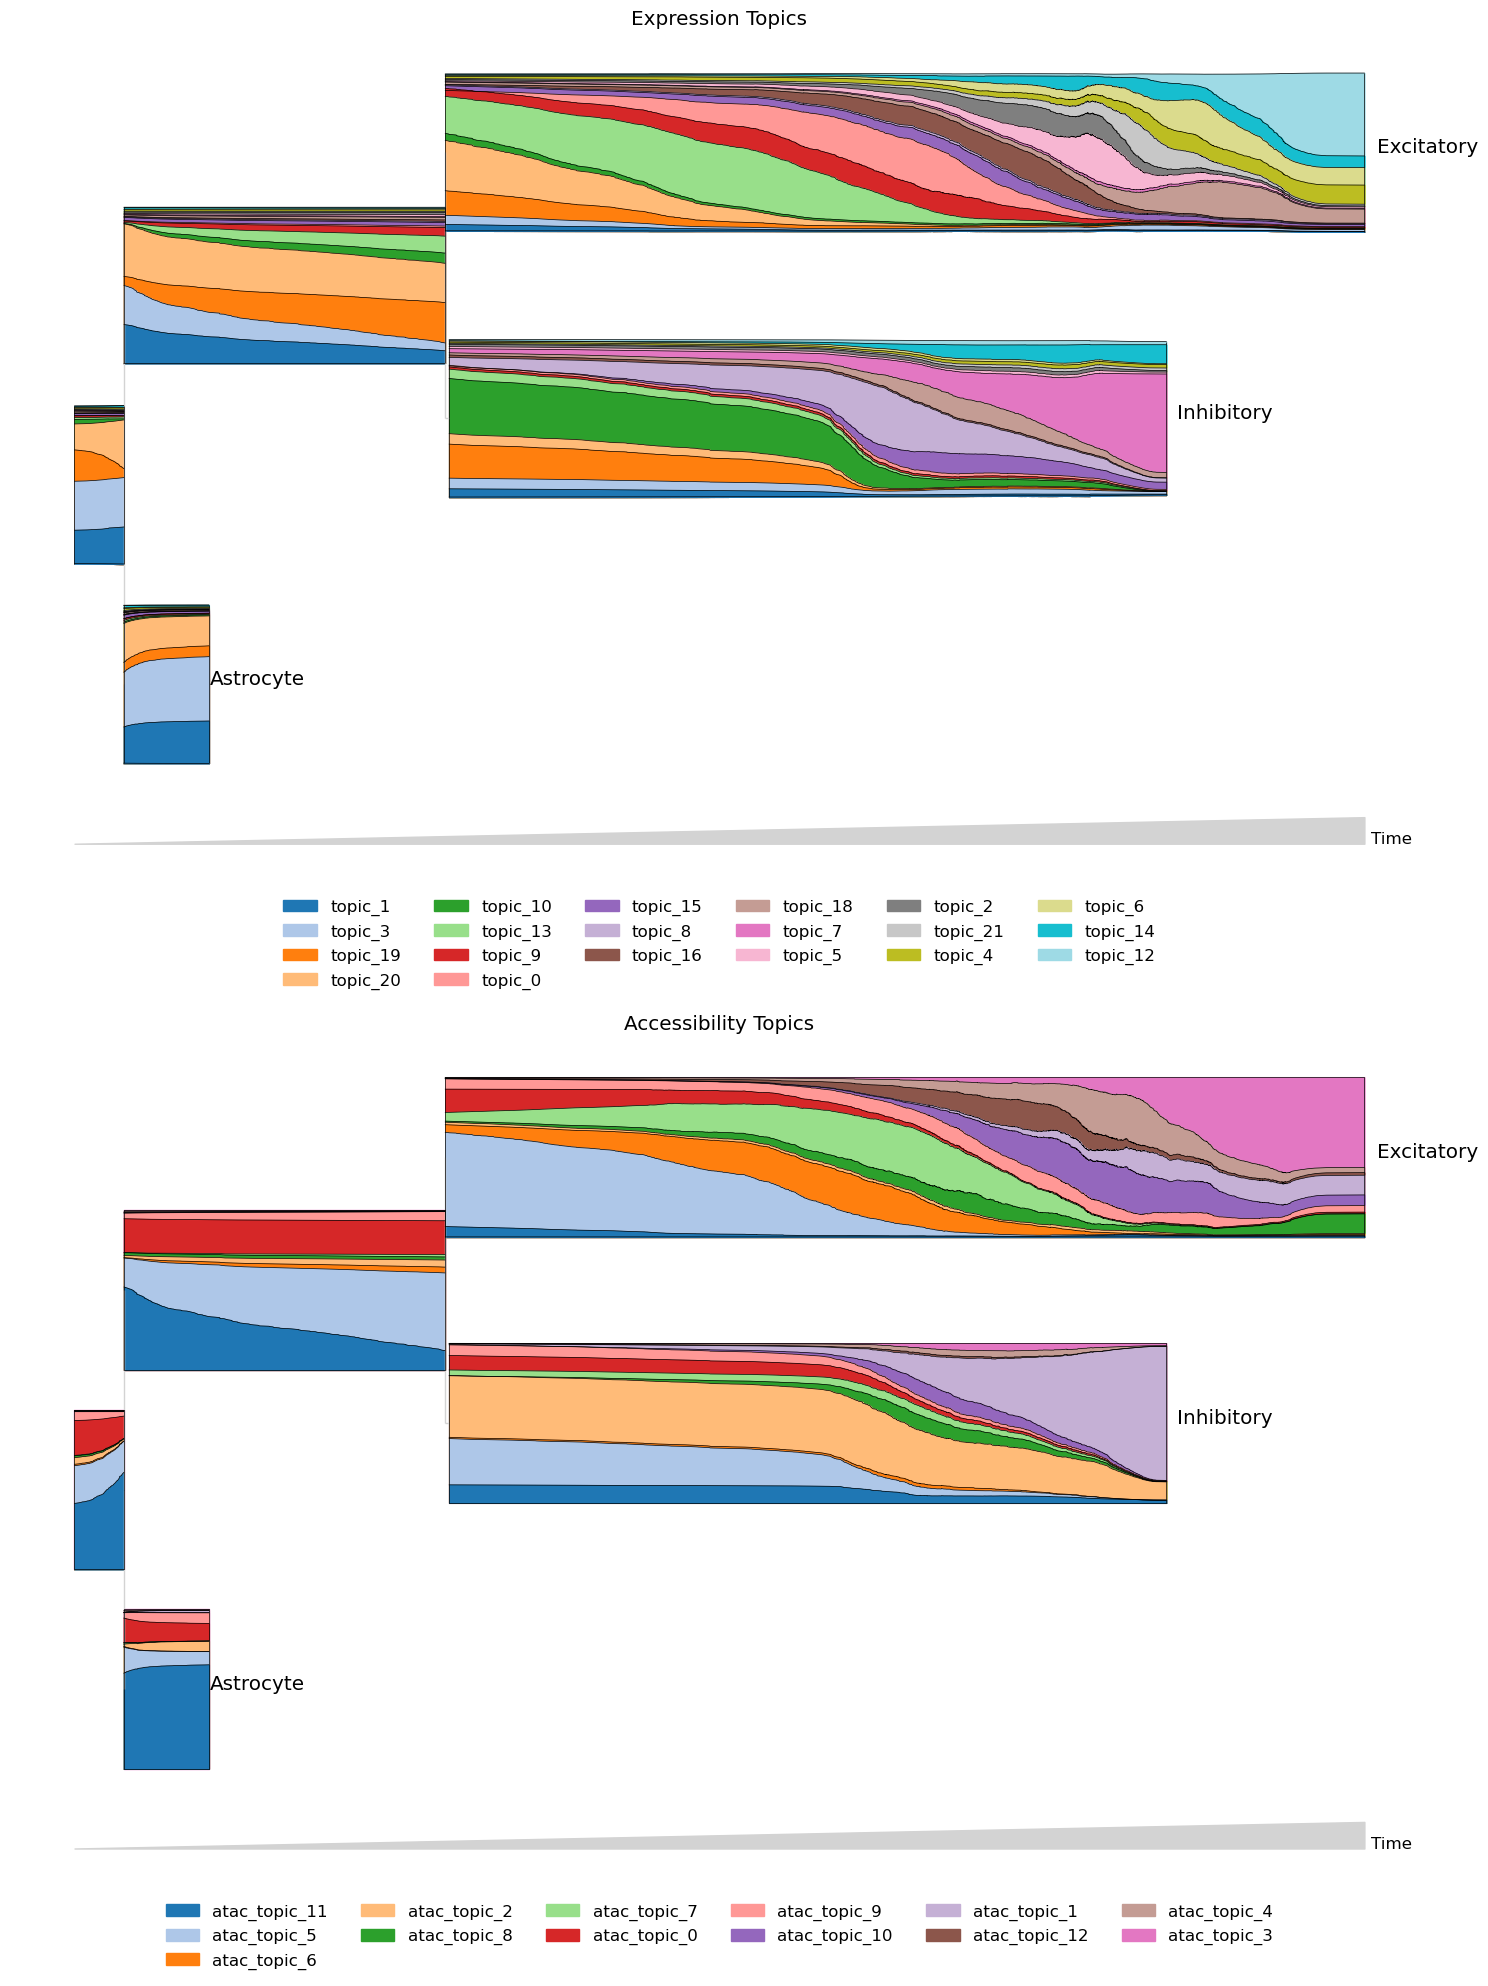

In [15]:
fig, ax = plt.subplots(2,1,figsize=(15,20))

mira.pl.plot_stream(rna_main, data=exp_topic_ordered, style='stream', 
                    palette='tab20', legend_cols=6, ax=ax[0], 
                    log_pseudotime=False, pseudotime_triangle=True, 
                    window_size=301, linewidth=0.5, height=10,
                    title='Expression Topics')

mira.pl.plot_stream(rna_main, data=acc_topic_prefixed, style='stream', 
                    palette='tab20', legend_cols=6, ax=ax[1], 
                    log_pseudotime=False, pseudotime_triangle=True, 
                    window_size=301, linewidth=0.5, height=10,
                    title = 'Accessibility Topics',
                    hide_feature_threshold=0)

## Expression topic enrichments

MIRA analyzes expression topic enrichments to reveal the pathways governing each cell state. For example, terminal inhibitory topic 7 was enriched for Bdnf and GABAergic signaling.

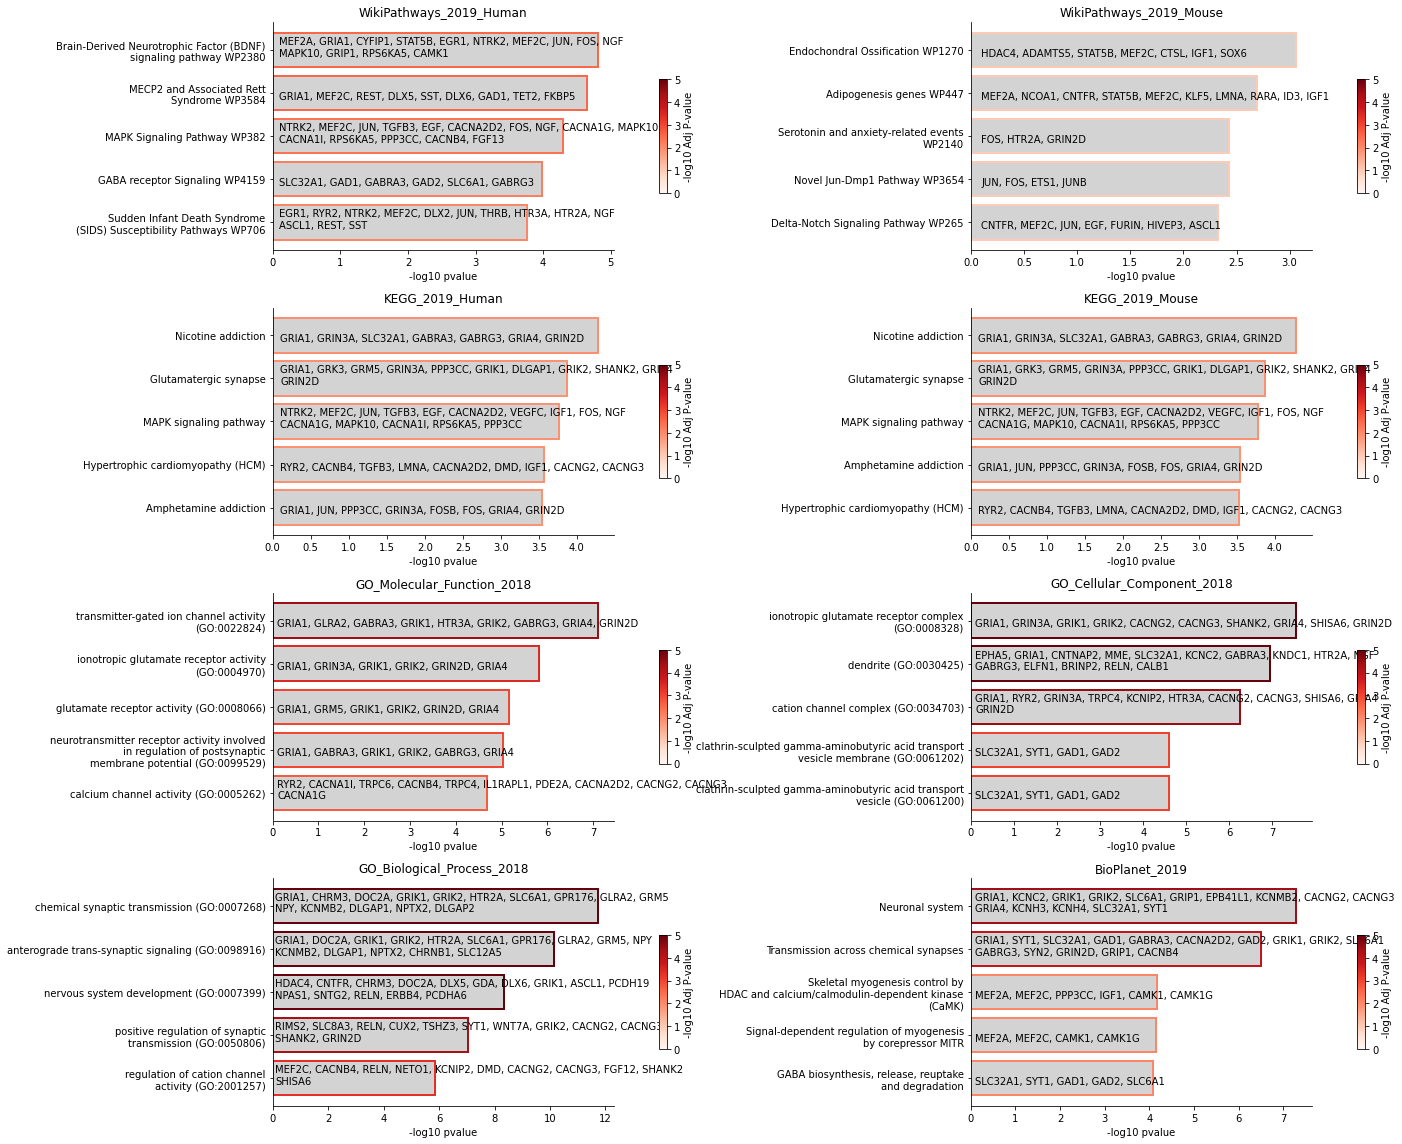

In [ ]:
# function to retrieve topic enrichments
def rna_topic_pathways(topic_num, top_n, show_top, enrichments_per_row, show_genes):
    rna_model.post_topic(topic_num, top_n=top_n) # post topic to enrichr
    rna_model.fetch_topic_enrichments(topic_num) # fetch results for ontologies (may provide a custom list)
    rna_model.plot_enrichments(topic_num, show_top=show_top,
                               show_genes=show_genes) # visualize enrichment results
    
rna_topic_pathways(7, 500, 5, 1, True)

Example genes may be plotted on the joint representation UMAP as normalized counts or MIRA imputed expression values.

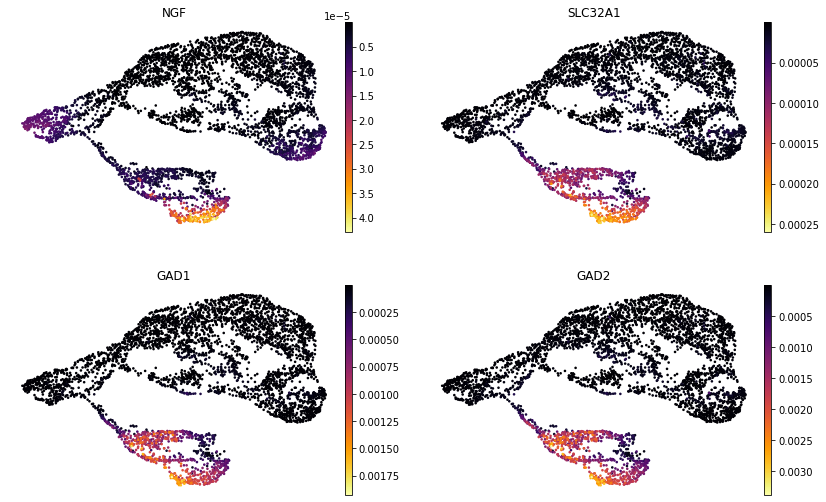

In [ ]:
umap = sc.pl.umap(rna_main, color=['NGF', 'SLC32A1', 'GAD1', 'GAD2'],
                  layer='imputed', frameon=False, color_map='inferno',
                  ncols=2, return_fig=True)
flip_axes(umap, True, True)

## Accessibility topic enrichments

MIRA analyzes accessibility topic enrichments to reveal the regulators associated with each cell state. 

In [ ]:
# reformat region names
chr_names = np.array([item.split(':')[0] for item in atac_main.var_names.values])
start_names = np.array([item.split(':')[1].split('-')[0] for item in atac_main.var_names.values])
end_names = np.array([item.split(':')[1].split('-')[1] for item in atac_main.var_names.values])

atac_main.var["chr"] = chr_names
atac_main.var["start"] = start_names
atac_main.var["end"] = end_names

In [ ]:
# load genome file
!wget --content-disposition 'http://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/latest/mm10.fa.gz'
!gunzip mm10.fa.gz

--2022-04-20 18:17:25--  http://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/latest/mm10.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898545591 (857M) [application/x-gzip]
Saving to: ‘mm10.fa.gz’

mm10.fa.gz          100%[===================>] 856.92M  48.3MB/s    in 18s     

2022-04-20 18:17:43 (46.8 MB/s) - ‘mm10.fa.gz’ saved [898545591/898545591]



To get motif hits, use the **mira.tl.get_motif_hits_in_peaks** method. One must provide the fasta file for your organism's genome, and have columns in your ATAC anndata marking the chromosome, start, and end of each peak.

In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO) 

In [ ]:
mira.tl.get_motif_hits_in_peaks(atac_main, genome_fasta='mm10.fa', 
                                pvalue_threshold=0.00001) # default is p<1e-5
motif_scores = atac_model.get_motif_scores(atac_main)

INFO:mira.tools.motif_scan:Getting peak sequences ...
172193it [00:05, 29755.44it/s]
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 1e-05 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits .

Imputing features:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mira/adata_interface/regulators.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  X = norm_scores,


In [ ]:
motif_scores.obsm['X_umap'] = atac_main.obsm['X_umap']
motif_scores.var['name'] = motif_scores.var.name.astype(str)
motif_scores.var = motif_scores.var.set_index('name')

For example, terminal inhibitory topic 1 was enriched for Egr1 motifs, a downstream Bdnf effector that directly activates GABAergic neurotransmission genes.

In [ ]:
mira.utils.subset_factors(atac_main, use_factors = rna_main.var_names)

INFO:mira.adata_interface.utils:Found 248 factors in expression data.


In [ ]:
atac_model.get_enriched_TFs(atac_main, topic_num=1)
pd.DataFrame(atac_model.get_enrichments(1)).sort_values('pval')

Finding enrichments:   0%|          | 0/248 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
122,MA0506.1,NRF1,NRF1,0.0,7.228888
114,MA0599.1,KLF5,KLF5,0.0,2.423027
46,MA0162.4,EGR1,EGR1,0.0,2.869723
50,MA1564.1,SP9,SP9,0.0,2.855290
146,MA1513.1,KLF15,KLF15,0.0,3.624575
...,...,...,...,...,...
232,MA0874.1,ARX,ARX,1.0,0.615660
20,MA0619.1,LIN54,LIN54,1.0,0.737750
111,MA0800.1,EOMES,EOMES,1.0,0.669309
12,MA0143.4,SOX2,SOX2,1.0,0.693519


MIRA calculates motif scores based on each cell's accessibility pattern. For example, comparing the motif scores for inhibitory-driving Ascl1 and excitatory-driving Neurod1 on the joint representation UMAP:

... storing 'parsed_name' as categorical


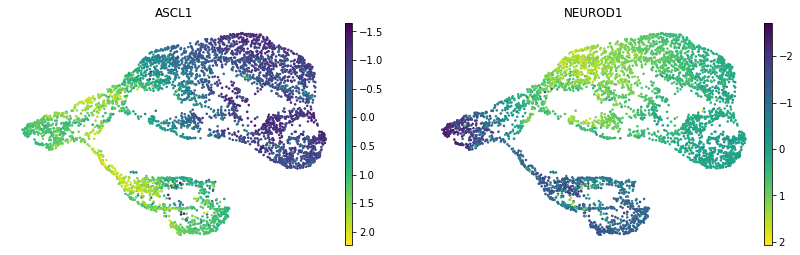

In [ ]:
umap = sc.pl.umap(motif_scores, color=['ASCL1', 'NEUROD1'], frameon=False,
           color_map='viridis', ncols=2, return_fig=True)
flip_axes(umap, True, True)

Motif scores can also be mapped onto the joint lineage tree to determine the regulators of key lineage branch points.

(<Figure size 720x360 with 1 Axes>, <AxesSubplot:>)

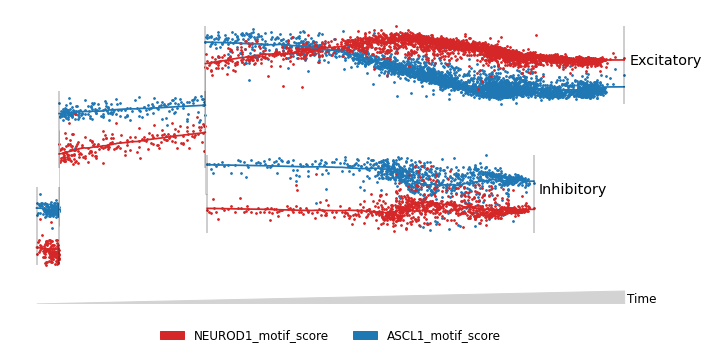

In [ ]:
rna_main.obs['ASCL1_motif_score'] = motif_scores.obs_vector('ASCL1')
rna_main.obs['NEUROD1_motif_score'] = motif_scores.obs_vector('NEUROD1')
mira.pl.plot_stream(rna_main[rna_main.obs.tree_states.str.contains('Excitatory|Inhibitory')],
                    data = ['NEUROD1_motif_score','ASCL1_motif_score'], 
                    style='scatter', log_pseudotime=False, window_size=101, 
                    linewidth=0.2, palette=['tab:red','tab:blue'], size=3)

## Regulatory Potential (RP) Modeling**

MIRA leverages RP modeling to integrate transcription and accessibility at the resolution of individual gene loci to determine how regulatory elements surrounding each gene influence its expression.

MIRA trains two RP models for each dataset: 1) one model based solely on local chromatin accessibility (±600 kilobases from gene transcriptional start sites) and 2) a second expanded model that is augmented with knowledge of genome-wide accessibility states encoded by MIRA’s accessibility topics. 

MIRA quantifies the regulatory influence of local chromatin accessibility on gene expression by comparing the local RP model with the second expanded model. Genes whose transcription is sufficiently predicted by the RP model based on local accessibility alone are defined as local chromatin accessibility-influenced transcriptional expression (LITE) genes. Genes whose expression is significantly better described by the model with genome-wide scope are defined as non-local chromatin accessibility-influenced transcriptional expression (NITE) genes. 

### RP model training

Import list of chromosome lengths and canonical transcriptional start sites:

Calculate distances from each region in the accessibility data:

In [ ]:
mira.datasets.mm10_tss_data()
mira.datasets.mm10_chrom_sizes()

INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10_tss_data.bed12
INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10.chrom.sizes


In [ ]:
mira.tl.get_distance_to_TSS(atac_main,
                            tss_data='mira-datasets/mm10_tss_data.bed12',
                            genome_file='mira-datasets/mm10.chrom.sizes')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


The **tss_data** parameter is a dataframe of TSS locations for your organism. The **gene_id**, ..., **gene_end** parameters indicate in which column of that dataframe MIRA can find the requisite information.

You can provide a customized list of genes to model. For example, highly variable genes and the top 200 genes from each expression topic:

In [ ]:
genes_to_model = set()
# add highly variable genes
genes_to_model.update(list(rna_main.var["gene_ids"][rna_main.var.highly_variable.values].index))
# add top 200 from each topic
for i in range(22):
    genes_to_model.update(rna_model.get_top_genes(i, top_n=200))
genes_to_model = genes_to_model - set(['TAFA1','PAKAP-1']) # removed unannotated genes
len(genes_to_model)

3797

Training the LITE RP model:

In [ ]:
lite_model = mira.rp.LITE_Model(expr_model=rna_model, 
                                accessibility_model=atac_model, 
                                genes=genes_to_model)
lite_model.fit(expr_adata=rna_main, atac_adata=atac_main)
lite_model.predict(expr_adata=rna_main, atac_adata=atac_main) # predicts expression levels given the accessibility state

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/9 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/9 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Fitting models:   0%|          | 0/3797 [00:00<?, ?it/s]

Predicting expression:   0%|          | 0/3796 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


Training the NITE RP model:

In [ ]:
nite_model = lite_model.spawn_NITE_model()
nite_model.predict(expr_adata=rna_main, atac_adata=atac_main)

Fitting models:   0%|          | 0/3797 [00:00<?, ?it/s]

Training NITE regulation model for CDH13 without providing pre-trained LITE models may cause divergence in statistical testing.


Predicting expression:   0%|          | 0/3796 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: NITE_prediction
INFO:mira.adata_interface.core:Added layer: NITE_logp


Quantifying LITE vs. NITE regulation:

In [ ]:
mira.tl.get_NITE_score_genes(rna_main)

INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts


## LITE vs. NITE regulation analysis

MIRA examines enrichments in NITE genes to reveal the modules regulated by NITE mechanisms.

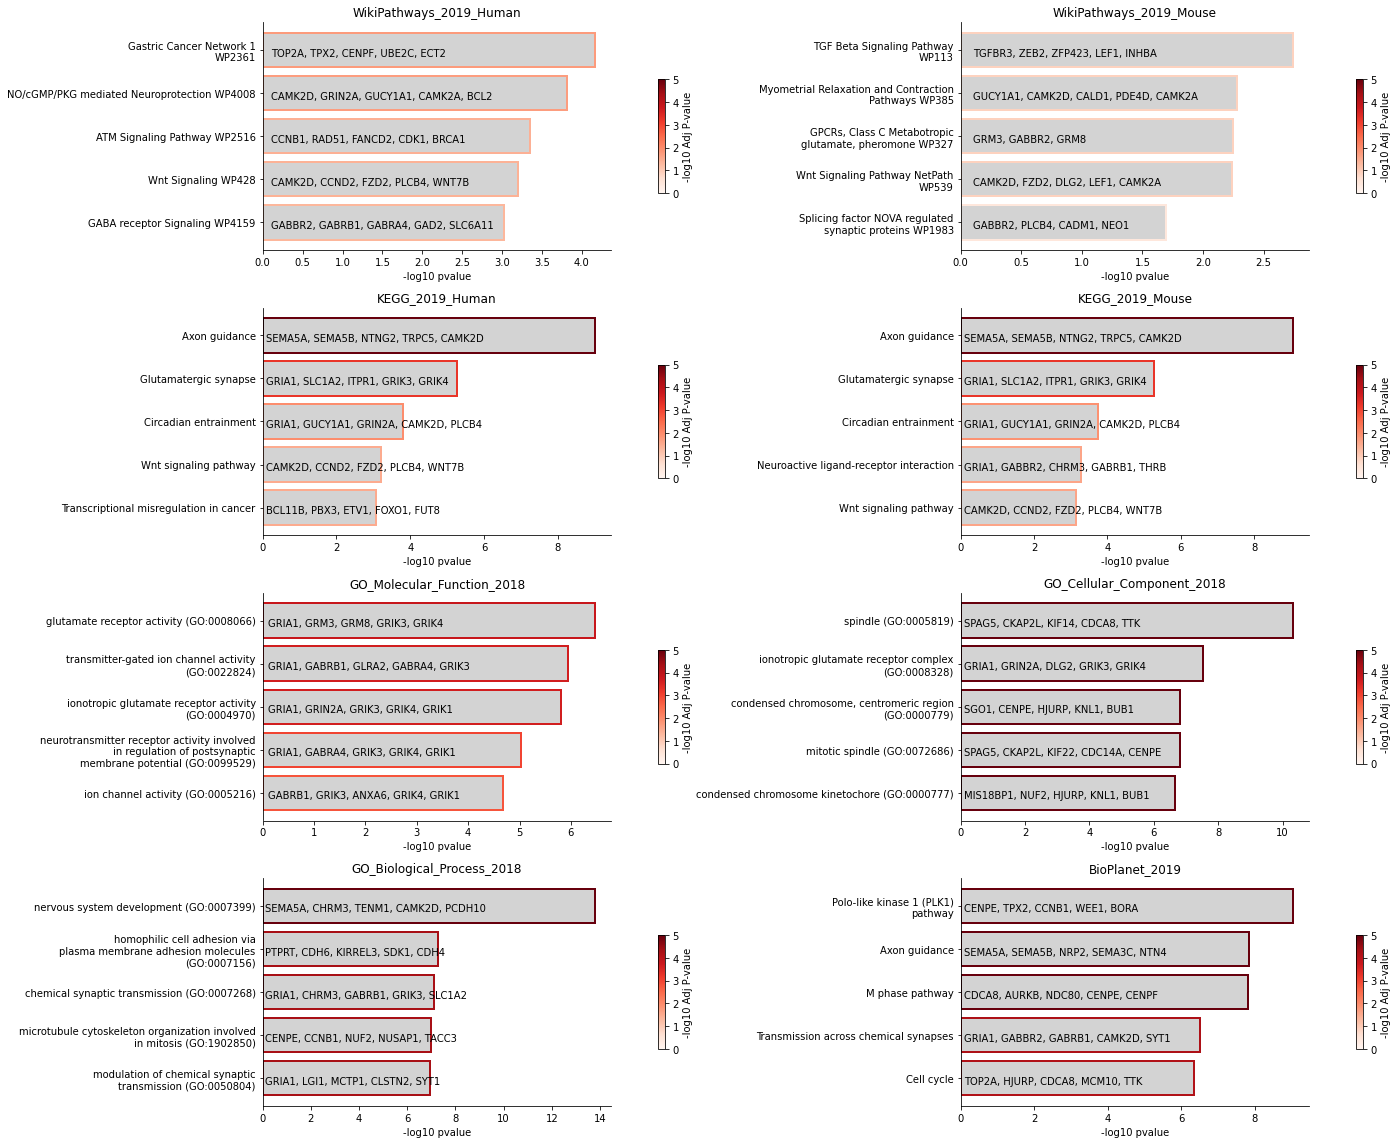

In [ ]:
plt.rcParams.update({'font.size': 10})
enrich_id = mira.tl.post_genelist(
    rna_main.var.dropna().sort_values('NITE_score').tail(500).index.values) 
global_enrichments = mira.tl.fetch_ontologies(enrich_id)
mira.pl.plot_enrichments(global_enrichments, show_top=5, 
                         show_genes=True, max_genes=5) 

NITE score can be plotted on the topic stream graph to reveal topics enriched for NITE regulation.

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'NITE Regulation of Expression Topics'}>)

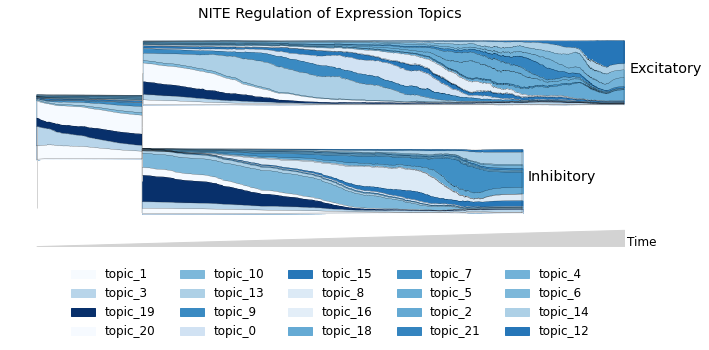

In [ ]:
nite_scores_df = pd.DataFrame(rna_main.var.NITE_score.dropna().sort_values())

topic_nite_scores_df = pd.DataFrame()
for i in range(22):
    top_genes = rna_model.get_top_genes(i, top_n=225)
    top_genes = [gene for gene in top_genes if gene in nite_scores_df.index]
    top_genes = top_genes[len(top_genes)-200:len(top_genes)]       
    
    nite_score_vals = [nite_scores_df.loc[gene][0] for gene in top_genes]
    topic_nite_scores_df[f"topic_{i}"] = nite_score_vals

ordered_topic_nite_scores_df = topic_nite_scores_df[exp_topic_ordered]
stream_vals = ordered_topic_nite_scores_df.mean(axis=0)

cmap = plt.cm.Blues
norms = (stream_vals-stream_vals.min())/(stream_vals.max()-stream_vals.min())
pal = cmap(norms)

mira.pl.plot_stream(rna_main[rna_main.obs.tree_states.isin(['Excitatory', 
                                                            'Inhibitory',
                                                    'Excitatory, Inhibitory'])], 
            data=exp_topic_ordered, palette=list(pal), style='stream',
            legend_cols=5, log_pseudotime=False, window_size=101, linewidth=0.2, 
            max_bar_height=0.6, title = 'NITE Regulation of Expression Topics')

MIRA defines the extent to which the LITE model over- or under-estimates expression in each cell as “chromatin differential”, highlighting cells where transcription is decoupled from shifts in local chromatin accessibility. 

INFO:mira.adata_interface.core:Added layer: chromatin_differential


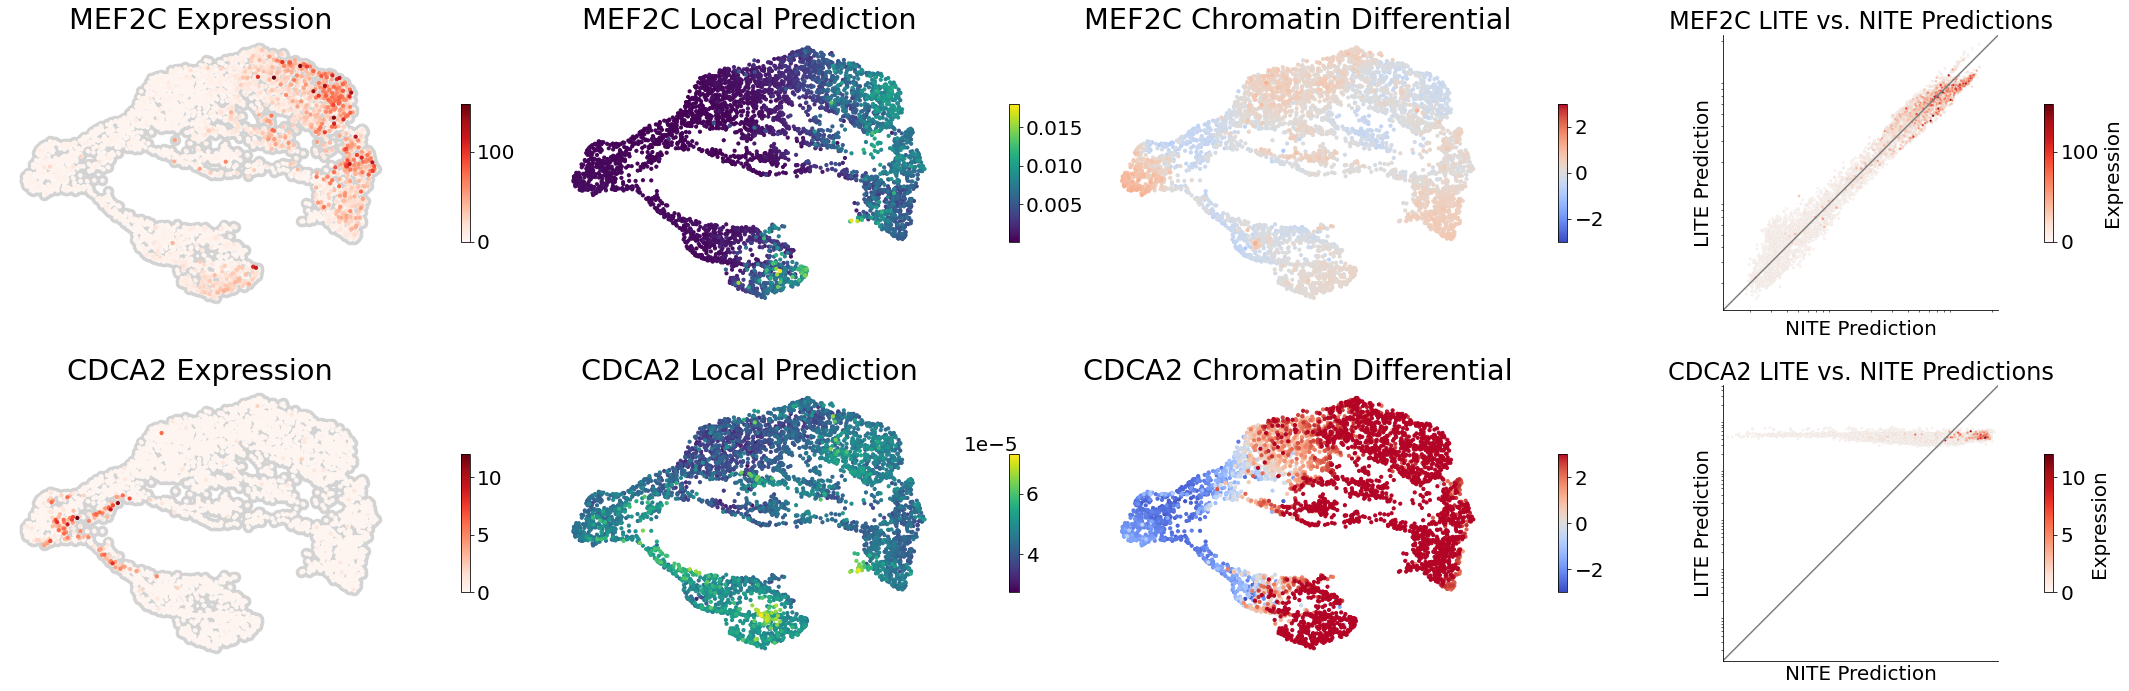

In [ ]:
plt.rcParams.update({'font.size': 20})
mira.tl.get_chromatin_differential(rna_main)
chrom_diff_pl = mira.pl.plot_chromatin_differential(rna_main, 
                                                    genes=['MEF2C','CDCA2'], 
                                                    size=10, height=5)
for row in chrom_diff_pl:
  for subplot in row[0:3]:
    subplot.axes.invert_xaxis()
    subplot.axes.invert_yaxis()

## Probabilistic in silico deletion to predict regulators and their targets

MIRA predicts key regulators at each locus by examining transcription factor motif enrichment or occupancy (if provided ChIP-seq data) within elements predicted to highly influence transcription at that locus by probabilistic in silico deletion (pISD).

For example, MIRA pISD can predict targets of early inhibitory Ascl1 vs. terminal inhibitory Egr1.

In [ ]:
mira.utils.subset_factors(atac_main, use_factors=['ASCL1','NEUROD1'])
lite_model.probabilistic_isd(expr_adata=rna_main, atac_adata=atac_main)
isd_df = pd.DataFrame(rna_main.varm['motifs-prob_deletion'], 
                      index = rna_main.var_names, 
                      columns=atac_main.uns['motifs']['name'])
ascl1_df = pd.DataFrame(isd_df['ASCL1'])
ascl1_df = ascl1_df.sort_values('ASCL1',axis=0, ascending=False)
neurod1_df = pd.DataFrame(isd_df['NEUROD1'])
neurod1_df = neurod1_df.sort_values('NEUROD1',axis=0, ascending=False)

INFO:mira.adata_interface.utils:Found 2 factors in expression data.
Predicting TF influence: 100%|██████████| 3797/3797 [03:28<00:00, 18.25it/s]
INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [ ]:
ascl1_df

,ASCL1
CACNA2D3,730.788325
CIT,444.091948
CDC14A,436.937080
TNC,377.768467
ELAVL2,362.946201
...,...
AP1S2,NaN
PIR,NaN
GPM6B,NaN
MT-ATP8,NaN


In [ ]:
neurod1_df

,NEUROD1
CARMIL3,702.561354
DHRS4,552.497222
MDK,518.287814
A930024E05RIK,444.511911
LRP8,308.048286
...,...
AP1S2,NaN
PIR,NaN
GPM6B,NaN
MT-ATP8,NaN


Additionally, MIRA pISD can predict regulators of genes, for example terminal inhibitory Egr1 vs. terminal excitatory Mef2c.

In [ ]:
mira.utils.subset_factors(atac_main, use_factors=rna_main.var_names)
lite_model.subset(['EGR1','MEF2C']).probabilistic_isd(expr_adata=rna_main, 
                                                      atac_adata=atac_main)
isd_df = pd.DataFrame(rna_main.varm['motifs-prob_deletion'], 
                      index = rna_main.var_names, 
                      columns=atac_main.uns['motifs']['name'])
egr1_df = isd_df[isd_df.index=='EGR1']
egr1_df = egr1_df.sort_values('EGR1', axis=1, ascending=False)
mef2c_df = isd_df[isd_df.index=='MEF2C']
mef2c_df = mef2c_df.sort_values('MEF2C',axis=1, ascending=False)

INFO:mira.adata_interface.utils:Found 248 factors in expression data.
Predicting TF influence: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]
INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [ ]:
egr1_df

,KLF9,PLAGL1,FOXP2,STAT3,ELF1,PBX3,KLF10,FOS::JUND,FOS::JUN,FOS::JUNB,FOSB::JUNB,JUNB,MXI1,FOS,INSM1,MAFK,FOS-1,HLF,MEIS1,RFX1,RFX4,RFX2,PROX1,PAX6,SCRT2,SOX5,RFX1,THAP11,RARA,IRF2,STAT2,ZIC2,ZIC1::ZIC2,MEIS2,NRF1,KLF3,RBPJ,MEF2A,KLF4,NFATC1,...,POU2F3,TGA6,ERF043,OS05G0497200,ARF29,MIXL1,PLT1,HB,BARX2,SIZF2,HSF4,TWIST2,HSFA6B,COG1,NHLH1,HAND2,SPDEF,DOF5.6,GATA14,ADR1,VIS,BACH1::MAFK,ARA,UGA3,CRZ1,CG9876,AT5G66940,YY2,ABF4,ZNF652,AGL16,MEF2D,ZNF684,NKX2-8,MYB1,UPC2,RUNX3,MYB65,YY1,AT1G75490
EGR1,6.648127,4.691517,4.689812,4.673928,4.264973,3.843565,3.842198,3.832137,3.832137,3.832137,3.822685,3.822685,3.764685,3.764685,3.75266,3.579575,3.566358,3.185519,2.973994,2.552709,2.469755,2.469755,2.402728,2.402728,2.402728,2.4022,1.044178,0.865548,0.836731,0.815963,0.791402,0.621658,0.61654,0.540867,0.497554,0.497554,0.497554,0.494506,0.361827,0.058912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mef2c_df

,ARID3A,KLF4,SOX5,EGR3,ID1,PLAG1,MEIS1,STAT2,FOS-1,STAT1::STAT2,FOXO4,FOXP1,POU3F2,DMRTA2,RUNX1,STAT3,FOXP2,FOXC1,ETV1,GABPA,TCF7L2,ELF1,ETV4,TBX15,LEF1,PBX2,TCF7,TCF7L1,NFIC,RARA::RXRG,DLX2,LHX5,NFATC1,NFATC3,RARA::RXRA,FOXO3,FOXJ2,NFE2L2,MEF2C,DMRT3,...,POU2F3,TGA6,ERF043,OS05G0497200,ARF29,MIXL1,PLT1,HB,BARX2,SIZF2,HSF4,TWIST2,HSFA6B,COG1,NHLH1,HAND2,SPDEF,DOF5.6,GATA14,ADR1,VIS,BACH1::MAFK,ARA,UGA3,CRZ1,CG9876,AT5G66940,YY2,ABF4,ZNF652,AGL16,MEF2D,ZNF684,NKX2-8,MYB1,UPC2,RUNX3,MYB65,YY1,AT1G75490
MEF2C,519.439829,241.570284,208.394754,141.516718,135.719896,132.815347,76.188012,35.967329,31.763487,29.754702,19.283958,13.464571,12.804426,12.092613,11.824704,11.138792,9.772067,9.737044,8.18417,8.178697,8.168631,8.16701,8.164231,8.15295,8.07795,7.152316,6.804814,6.728358,6.573017,6.200751,5.888207,5.552202,5.3028,5.288381,5.274196,5.2449,5.2449,4.88439,4.339196,4.31557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
